In [51]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/image-segmentation/
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from fcnn_model import FCNN8, VGGNet
from unet_model import VGGNET as UNET_VGG
from segnet_model import SEGNET
from camvid_dataloader import CamVidDataset
from matplotlib import pyplot as plt
import numpy as np
import os
from numpy import genfromtxt
import imageio
from skimage.transform import resize
import random
from torchvision import models
from torchvision.models.vgg import VGG


from torchvision.models import vgg16_bn
__all__ = ['vgg16bn_unet']

nworkers = 2
nclasses = 32
batch_size = 8
epochs = 100
lr = 0.0002
weight_decay = 0.0005
device = "cuda" if torch.cuda.is_available() else "cpu"

root_dir   = "CamVid/"
train_file = os.path.join(root_dir, "train.txt")
val_file   = os.path.join(root_dir, "val.txt")


fcnn_checkpoint = torch.load('cpts/fcnn8.cpt')
segnet_checkpoint = torch.load('cpts/segnet.cpt')
unet_checkpoint = torch.load('cpts/unet.cpt')
unet_adapt_checkpoint = torch.load('cpts/unet_adapt.cpt')

# pick random file
random.seed(1486438)
files=os.listdir('CamVid/val/')
img_path=random.choice(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/image-segmentation


Load results

In [52]:
# load loss, pixel accuracy and iou
fcnn_loss_vals = genfromtxt("results/fcnn8_loss.txt", delimiter=',')
fcnn_avg_pixel_acc_vals = genfromtxt("results/fcnn8_pixel_acc.txt", delimiter=',')
fcnn_avg_iou_vals = genfromtxt("results/fcnn8_iou.txt", delimiter=',')

fcnn_loss_vals_test = genfromtxt("results/fcnn8_loss_test.txt", delimiter=',')
fcnn_avg_pixel_acc_vals_test = genfromtxt("results/fcnn8_pixel_acc_test.txt", delimiter=',')
fcnn_avg_iou_vals_test = genfromtxt("results/fcnn8_iou_test.txt", delimiter=',')

segnet_loss_vals = genfromtxt("results/segnet_loss.txt", delimiter=',')
segnet_avg_pixel_acc_vals = genfromtxt("results/segnet_pixel_acc.txt", delimiter=',')
segnet_avg_iou_vals = genfromtxt("results/segnet_iou.txt", delimiter=',')

segnet_loss_vals_test = genfromtxt("results/segnet_loss_test.txt", delimiter=',')
segnet_avg_pixel_acc_vals_test = genfromtxt("results/segnet_pixel_acc_test.txt", delimiter=',')
segnet_avg_iou_vals_test = genfromtxt("results/segnet_iou_test.txt", delimiter=',')

unet_loss_vals = genfromtxt("results/unet_loss.txt", delimiter=',')
unet_avg_pixel_acc_vals = genfromtxt("results/unet_pixel_acc.txt", delimiter=',')
unet_avg_iou_vals = genfromtxt("results/unet_iou.txt", delimiter=',')

unet_loss_vals_test = genfromtxt("results/unet_loss_test.txt", delimiter=',')
unet_avg_pixel_acc_vals_test = genfromtxt("results/unet_pixel_acc_test.txt", delimiter=',')
unet_avg_iou_vals_test = genfromtxt("results/unet_iou_test.txt", delimiter=',')


Plot results

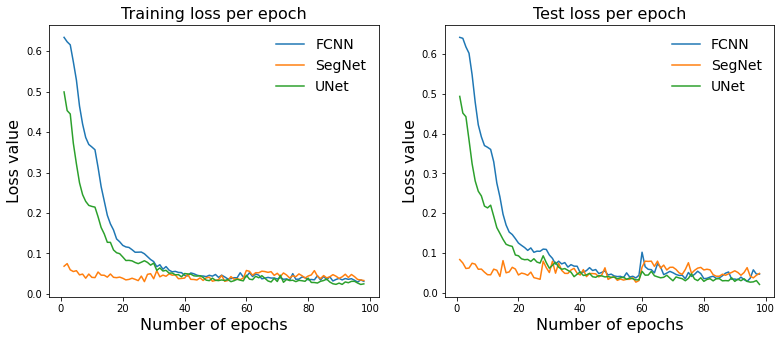

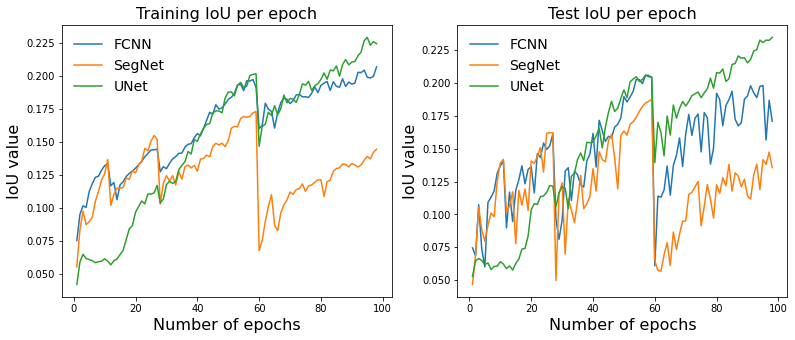

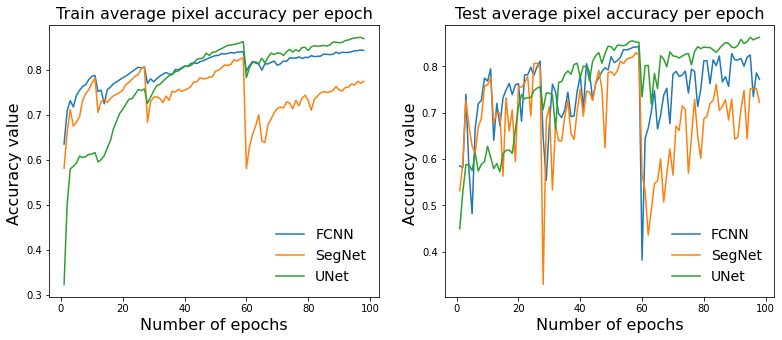

In [53]:
# Plot train loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(fcnn_loss_vals, linewidth=1.5)
plt.plot(segnet_loss_vals, linewidth=1.5)
plt.plot(unet_loss_vals, linewidth=1.5)
plt.title('Training loss per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Loss value', fontsize = 16)
plt.legend(['FCNN', 'SegNet', 'UNet'],
           prop={'size': 14},           
            frameon=False)
# Plot test loss per epoch
plt.subplot(1, 2, 2)
plt.plot(fcnn_loss_vals_test, linewidth=1.5)
plt.plot(segnet_loss_vals_test, linewidth=1.5)
plt.plot(unet_loss_vals_test, linewidth=1.5)
plt.title('Test loss per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Loss value', fontsize = 16)
plt.legend(['FCNN', 'SegNet', 'UNet'],
           prop={'size': 14},           
            frameon=False)
plt.savefig('figs/test_vs_test_loss.png')

# Plot train IoU
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(fcnn_avg_iou_vals, linewidth=1.5)
plt.plot(segnet_avg_iou_vals, linewidth=1.5)
plt.plot(unet_avg_iou_vals, linewidth=1.5)
plt.title('Training IoU per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('IoU value', fontsize = 16)

plt.legend(['FCNN', 'SegNet', 'UNet'],
           prop={'size': 14},           
            frameon=False)
# Plot test IoU
plt.subplot(1, 2, 2)
plt.plot(fcnn_avg_iou_vals_test, linewidth=1.5)
plt.plot(segnet_avg_iou_vals_test, linewidth=1.5)
plt.plot(unet_avg_iou_vals_test, linewidth=1.5)
plt.title('Test IoU per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('IoU value', fontsize = 16)

plt.legend(['FCNN', 'SegNet', 'UNet'],
           prop={'size': 14},           
            frameon=False)
plt.savefig('figs/test_vs_test_iou.png')

# Plot train pixel accuracy per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(fcnn_avg_pixel_acc_vals, linewidth = 1.5)
plt.plot(segnet_avg_pixel_acc_vals, linewidth = 1.5)
plt.plot(unet_avg_pixel_acc_vals, linewidth = 1.5)
plt.title('Train average pixel accuracy per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Accuracy value ', fontsize = 16)
plt.legend(['FCNN', 'SegNet', 'UNet'], prop={'size': 14},           
            frameon=False)

# Plot train pixel accuracy per epoch
plt.subplot(1,2,2)
plt.plot(fcnn_avg_pixel_acc_vals_test, linewidth = 1.5)
plt.plot(segnet_avg_pixel_acc_vals_test, linewidth = 1.5)
plt.plot(unet_avg_pixel_acc_vals_test, linewidth = 1.5)
plt.title('Test average pixel accuracy per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Accuracy value ', fontsize = 16)
plt.legend(['FCNN', 'SegNet', 'UNet'], prop={'size': 14},           
            frameon=False)
plt.savefig('figs/test_vs_test_acc.png')


Plot model predictions

In [64]:
138404328 / 1000000

138.404328

In [54]:
vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcnn_model = FCNN8(pretrained=vgg_model, nclasses=nclasses).to(device)
fcnn_model.load_state_dict(fcnn_checkpoint['model_state_dict'])
fcnn_model.eval()

vgg_model = models.vgg16(pretrained=True)
segnet_model = SEGNET(pretrained=vgg_model, nclasses=nclasses).to(device)
segnet_model.load_state_dict(segnet_checkpoint['model_state_dict'])
segnet_model.eval()

def vgg16bn_unet(nclasses, pretrained = False):    
    return UNET_VGG(vgg16_bn, pretrained=pretrained, nclasses=nclasses)
vgg_model = models.vgg16(pretrained=True)
unet_model = vgg16bn_unet(nclasses = nclasses, pretrained=True).to(device)
unet_model.load_state_dict(unet_checkpoint['model_state_dict'])
unet_model.eval()

VGGNET(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [55]:
label_colors_file = os.path.join(root_dir, "label_colors.txt")
label2color = {}
color2label = {}
label2index = {}
index2label = {}

means = np.array([103.939, 116.779, 123.68]) / 255.

def parse_label():
    f = open(label_colors_file, "r").read().split("\n")[:-1]  # ignore the last empty line
    for idx, line in enumerate(f):
        label = line.split()[-1]
        color = tuple([int(x) for x in line.split()[:-1]])
        #print(label, color)
        label2color[label] = color
        color2label[color] = label
        label2index[label] = idx
        index2label[idx]   = label

parse_label()
def test_img(img_path, model, model_name):
    #img = scipy.misc.imread(img_path, mode='RGB')
    img = imageio.imread(img_path, pilmode="RGB")
    imageio.imsave('figs/'+model_name+'_test.jpg', img)
    h, w, c = img.shape[0], img.shape[1], img.shape[2]
    val_h = int(h / 32) * 32
    val_w = w
    #img = scipy.misc.imresize(img, (val_h, val_w), interp='bilinear', mode=None)
    img = resize(img, (val_h, val_w), order=1, mode="constant")

    img = img[:, :, ::-1]
    img = np.transpose(img, (2, 0, 1)) #/ 3.
    img[0] -= means[0]
    img[1] -= means[1]
    img[2] -= means[2]

    inputs = torch.from_numpy(img.copy()).float()
    inputs = torch.unsqueeze(inputs, 0).cuda()
    # output = model(inputs)
    output = model(inputs)
    output = output.data.cpu().numpy()
    #print("OUT SHAPE: ", output.shape)
    N, _, h, w = output.shape
    assert (N == 1)
    pred = output.transpose(0, 2, 3, 1).reshape(-1, nclasses).argmax(axis=1).reshape(h, w)

    pred_img = np.zeros((val_h, val_w, 3), dtype=np.float32)
    for cls in range(nclasses):
        pred_inds = pred == cls
        label = index2label[cls]
        color = label2color[label]
        pred_img[pred_inds] = color
    #pred_img = scipy.misc.imresize(pred_img, (h, w), interp='bilinear', mode=None)
    pred_img = resize(pred_img, (h, w), order=1, mode="constant")
    #pred_img = pred_img.astype(np.uint8)
    #scipy.misc.imsave('result.png', pred_img)
    imageio.imsave('figs/'+model_name+'_segmentation.jpg', pred_img)
    #return output

In [56]:
test_img('CamVid/val/'+ img_path, model = fcnn_model, model_name = 'fcnn')

In [57]:
test_img('CamVid/val/'+ img_path, model = segnet_model, model_name = 'segnet')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [59]:
test_img('CamVid/val/'+ img_path, model = unet_model, model_name = 'unet')